# 한국어 Chatbot 만들기 (Transformer)

* [동빈나 Transformer](https://www.youtube.com/watch?v=AA621UofTUA&t=225s)
* [Michigan youtube](https://www.youtube.com/playlist?list=PL5-TkQAfAZFbzxjBHtzdVCWE0Zbhomg7r)
* [miniGPT](https://github.com/karpathy/minGPT/blob/master/mingpt/model.py)
* [huggingface 다양한 모델](https://github.com/huggingface/transformers/tree/main/src/transformers/models)
* [Efficient Transformers: A Survey](https://arxiv.org/pdf/2009.06732.pdf)
* [facebookresearch/xformers](https://github.com/facebookresearch/xformers)

In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

## 데이터 수집하기
* 한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용   
[songys/Chatbot_data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)
    + 챗봇 트레이닝용 문답 페어 11,876개
    + 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링

In [3]:
data_path = os.getenv('HOME')+'/aiffel/transformer_chatbot/data/ChatbotData.csv'
data =  pd.read_csv(data_path)
type(data)

pandas.core.frame.DataFrame

In [4]:
data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


## 데이터 전처리

In [5]:
def preprocess_sentence(sentence):
    # 문장의 앞뒤 공백을 제거
    sentence = sentence.strip()
    
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "12시 땡!" => "12시 땡 !"와 같이
    # 땡와 느낌표(구두점) 사이에 거리를 만듭니다. 
    # (r"")에서 r은 raw line. 예시) '12시 땡!\n'까지 나타내는 표현식
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # 공백이 연속으로 있을 때 하나로.
    sentence = re.sub(r'[" "]+', " ", sentence)
    # (ㄱ-ㅎ,가-힣,a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체
    sentence = re.sub(r'[^0-9ㄱ-ㅎ가-힣a-zA-Z.?!,]+', " ", sentence)
    # 숫자들을 모두 1로 통일 해보았습니다.
    sentence = re.sub(r'[0-9]+', "1", sentence)
    return sentence.strip()

In [6]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations(data):
    # Q의 중복되는 문장 제거.
    data.drop_duplicates(subset = ['Q'], inplace=True)
    
    question = list(map(preprocess_sentence,data['Q']))
    answer = list(map(preprocess_sentence,data['A']))

    return question, answer

In [7]:
questions, answers = load_conversations(data)
print('전체 샘플 수 :', len(questions))

print('전처리 후의 100번째 질문 샘플: {}'.format(questions[99]))
print('전처리 후의 100번째 답변 샘플: {}'.format(answers[99]))
print('\n전처리 후의 50번째 질문 샘플: {}'.format(questions[49]))
print('전처리 후의 50번째 답변 샘플: {}'.format(answers[49]))

전체 샘플 수 : 11662
전처리 후의 100번째 질문 샘플: 거지 같이 일해 놓고 갔어
전처리 후의 100번째 답변 샘플: 일 못하는 사람이 있으면 옆에 있는 사람이 더 힘들죠 .

전처리 후의 50번째 질문 샘플: 감 말랭이 먹고 싶다 .
전처리 후의 50번째 답변 샘플: 맛있게 드세요 .


## TensorFlow Datasets `SubwordTextEncoder` 를 토크나이저로 사용

In [8]:
import tensorflow_datasets as tfds
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

#### 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.

In [9]:

START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

START_TOKEN의 번호 : [8086]
END_TOKEN의 번호 : [8087]
8088


#### 문장의 최대길이를 정한다.

In [12]:
total_data_text = questions + answers

num_tokens = [len(tokenizer.encode(text)) for text in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 3*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 3 * np.std(num_tokens)
MAX_LENGTH = int(max_tokens)
print('pad_sequences maxlen : ', MAX_LENGTH)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  5.671625793174413
문장길이 최대 :  29
문장길이 표준편차 :  2.5626432385891844
pad_sequences maxlen :  13
전체 문장의 0.9892385525638827%가 maxlen 설정값 이내에 포함됩니다. 


#### 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩

In [16]:
def tokenize_and_filter(Questions, Answers):
    tokenized_questions, tokenized_answers = [], []
  
    for (sentence1, sentence2) in zip(Questions, Answers):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_questions.append(sentence1)
            tokenized_answers.append(sentence2)
  
    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_questions = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_questions, maxlen=MAX_LENGTH, padding='post')
    tokenized_answers = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_answers, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_questions, tokenized_answers

questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8088
필터링 후의 질문 샘플 개수: 11000
필터링 후의 답변 샘플 개수: 11000


In [21]:
BATCH_SIZE = 32
BUFFER_SIZE = 5000 # 랜덤을 설정할 때 가지고 올 데이터 개수

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

<PrefetchDataset shapes: ({inputs: (None, 13), dec_inputs: (None, 12)}, {outputs: (None, 12)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>

## 트랜스포머 모델 구현
#### Positional Encoding Layer

[![positionalEncoding](https://oopy.lazyrockets.com/api/v2/notion/image?src=https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F69ff2718-58c7-4107-ac7c-85fb2ce71e94%2Fcut1.gif&blockId=13b5a2b4-2938-4ba3-97a0-0e836cb1d704)](https://www.blossominkyung.com/deeplearning/transfomer-positional-encoding)



In [22]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

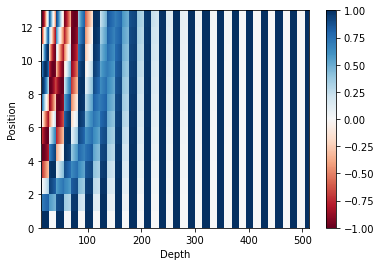

In [25]:
sample_pos_encoding = PositionalEncoding(MAX_LENGTH,512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((MAX_LENGTH, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

#### Multi Head Attention(멀티-헤드 어텐션)

In [26]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

In [27]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query,batch_size)
        key = self.split_heads(key,batch_size)
        value = self.split_heads(value,batch_size)
        
        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

#### 마스킹

In [28]:
# 패딩 마스킹(Padding Masking)
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]
# 룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

#### 인코딩

In [29]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
        })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [30]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

        return tf.keras.Model(
            inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [31]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [32]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [33]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [34]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    2597632     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [35]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [36]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

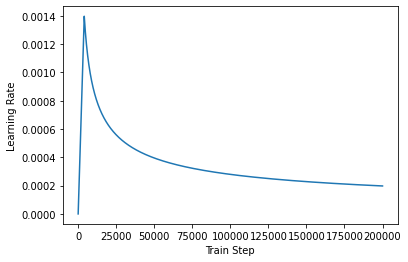

In [37]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [38]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
        learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [39]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
344/344 [==============================] - 13s 23ms/step - loss: 4.1407 - accuracy: 0.1225
Epoch 2/50
344/344 [==============================] - 8s 22ms/step - loss: 3.0777 - accuracy: 0.1653
Epoch 3/50
344/344 [==============================] - 8s 22ms/step - loss: 2.7742 - accuracy: 0.1798
Epoch 4/50
344/344 [==============================] - 8s 23ms/step - loss: 2.5266 - accuracy: 0.1956
Epoch 5/50
344/344 [==============================] - 8s 23ms/step - loss: 2.2443 - accuracy: 0.2195
Epoch 6/50
344/344 [==============================] - 8s 22ms/step - loss: 1.9169 - accuracy: 0.2540
Epoch 7/50
344/344 [==============================] - 8s 23ms/step - loss: 1.5592 - accuracy: 0.2945
Epoch 8/50
344/344 [==============================] - 8s 22ms/step - loss: 1.2058 - accuracy: 0.3401
Epoch 9/50
344/344 [==============================] - 8s 22ms/step - loss: 0.8872 - accuracy: 0.3843
Epoch 10/50
344/344 [==============================] - 8s 23ms/step - loss: 0.6324 - accur

In [40]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

      # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [41]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [42]:
sentence_generation('뭐하고 있어?')

입력 : 뭐하고 있어?
출력 : 얼굴 보고만 있어도 좋죠 .


'얼굴 보고만 있어도 좋죠 .'

In [45]:
sentence_generation('연애 해봤어?')

입력 : 연애 해봤어?
출력 : 해봤어요 .


'해봤어요 .'

In [46]:
sentence_generation('이름이 뭐야?')

입력 : 이름이 뭐야?
출력 : 위로봇이요 .


'위로봇이요 .'

In [47]:
sentence_generation('밥 뭐 먹을까?')

입력 : 밥 뭐 먹을까?
출력 : 맛있는 거 드세요 .


'맛있는 거 드세요 .'